## Visualizing feature importance in multiclass models

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(magick))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ComplexHeatmap))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [2]:
# Set output directory
output_dir <- file.path("figures", "individual_coefficient_heatmaps")

heatmap_real_file <- file.path(output_dir, "compiled_real_coefficient_heatmaps.png")
heatmap_shuffled_file <- file.path(output_dir, "compiled_shuffled_coefficient_heatmaps.png")

In [3]:
# Load model coefficients
coef_dir <- file.path("../4.interpret_model/coefficients/")
coef_file <- file.path(coef_dir, "compiled_coefficients.tsv")

coef_df <- readr::read_tsv(
    coef_file,
    col_types = readr::cols(
        .default = "d",
        "Feature_Name" = "c",
        "Phenotypic_Class" = "c",
        "feature_type" = "c",
        "shuffled" = "c"
    )
) %>%
    dplyr::select(!`...1`) 

print(dim(coef_df))
head(coef_df, 3)

New names:
• `` -> `...1`


[1] 86220     5


Feature_Name,Phenotypic_Class,Coefficent_Value,shuffled,feature_type
<chr>,<chr>,<dbl>,<chr>,<chr>
CP__AreaShape_Area,ADCCM,0.00822653,False,CP
CP__AreaShape_Area,Anaphase,-0.01862480,False,CP
CP__AreaShape_Area,Apoptosis,-0.02102483,False,CP


In [4]:
# Set constants for how to split feature name into interpretable parts
first_component_split <- c(
    "feature_space",
    "feature_name"
)

dp_feature_components <- c(
    "model",
    "component_idx"
)

cp_feature_components <- c(
    "feature_group",
    "measurement",
    "channel", 
    "parameter1", 
    "parameter2",
    "parameter3"
)

metadata_annotation_options <- list(
    "CP" = cp_feature_components,
    "DP" = dp_feature_components,
    "CP_and_DP" = dp_feature_components
)

In [5]:
# Create matrices for each combination of shuffled and feature type
feature_matrix_list <- list()
for (shuffled_value in unique(coef_df$shuffled)) {
    for (feature_type_value in unique(coef_df$feature_type)) {
        list_name_index <- paste0(feature_type_value, "__", shuffled_value)
        print(paste("Transforming model coefficients:", list_name_index))
        # Subset the coeficient dataframe
        coef_subset <- coef_df %>%
            dplyr::filter(
                shuffled == !!shuffled_value,
                feature_type == !!feature_type_value
            ) %>%
            dplyr::select(-c("shuffled", "feature_type")) %>%
            tidyr::pivot_wider(names_from = Feature_Name, values_from = Coefficent_Value)

        # Make data ready for matrix transformation
        coef_subset$Phenotypic_Class <- factor(
            coef_subset$Phenotypic_Class,
            levels=unique(coef_subset$Phenotypic_Class)
        )
        coef_subset_mat <- as.matrix(coef_subset[, -1])
        rownames(coef_subset_mat) <- coef_subset$Phenotypic_Class

        # Process metadata for inclusion in heatmap annotation
        metadata_subset <- dplyr::as_tibble(
            colnames(coef_subset_mat),
            .name_repair = function(x) "feature"
            ) %>%
            tidyr::separate(
                feature,
                into = first_component_split,
                sep = "__",
                remove = FALSE
            ) %>%
            tidyr::separate(
                "feature_name",
                into = metadata_annotation_options[[feature_type_value]],
                sep = "_",
                remove = FALSE
            )
        metadata_subset <- as.matrix(metadata_subset)
        rownames(metadata_subset) <- colnames(coef_subset_mat)
        
        # Store in list
        feature_matrix_list[[list_name_index]] <- list()
        feature_matrix_list[[list_name_index]][["coef_matrix"]] <- coef_subset_mat
        feature_matrix_list[[list_name_index]][["metadata_annotation"]] <- metadata_subset
    }
}

[1] "Transforming model coefficients: CP__False"


Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 105 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


[1] "Transforming model coefficients: CP_and_DP__False"


Warning message:
“Expected 2 pieces. Additional pieces discarded in 138 rows [3, 4, 5, 6, 7, 8, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...].”


[1] "Transforming model coefficients: DP__False"
[1] "Transforming model coefficients: CP__True"


Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 105 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


[1] "Transforming model coefficients: CP_and_DP__True"


Warning message:
“Expected 2 pieces. Additional pieces discarded in 138 rows [3, 4, 5, 6, 7, 8, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...].”


[1] "Transforming model coefficients: DP__True"


In [6]:
model_heatmap_file_names <- list()
for (model in names(feature_matrix_list)) {
    print(paste("Generating heatmap for:", model))

    # Create output file
    output_file <- file.path(output_dir, paste0("heatmap_", model, ".pdf"))

    # Store model file in a list for downstream loading with magick
    model_heatmap_file_names[model] <- output_file
    
    # Create components for plotheatmap_gg_list[["CP__False"]]ting and subsetting
    model_split_details <- unlist(stringr::str_split(model, "__"))
    feature_space <- model_split_details[1]
    shuffled_or_not <- model_split_details[2]

    if (shuffled_or_not == "False") {
        column_title = "Real data (final model)"
    } else {
        column_title = "Shuffled data"
    }

    # Generate heatmaps depending on the feature space
    if (feature_space == "CP") {
        column_title <- paste("CellProfiler features", column_title)
        coef_heatmap <- Heatmap(
            feature_matrix_list[[model]][["coef_matrix"]],
            top_annotation = HeatmapAnnotation(
                df = as.data.frame(feature_matrix_list[[model]][["metadata_annotation"]]) %>%
                    dplyr::select(feature_group),
                col = list(feature_group = cp_feature_group_colors),
                annotation_legend_param = list(feature_group = list(title = "CP feature\ngroup"))
            ),
            column_split = as.data.frame(feature_matrix_list[[model]][["metadata_annotation"]])$feature_group,
            column_title = column_title,
            name = "ML Coefficient",
            show_column_names = FALSE
        )

    } else if (feature_space == "CP_and_DP") {
        column_title <- paste("CP and DP features", column_title)
        coef_heatmap <- Heatmap(
            feature_matrix_list[[model]][["coef_matrix"]],
            top_annotation = HeatmapAnnotation(
                df = as.data.frame(feature_matrix_list[[model]][["metadata_annotation"]]) %>%
                    dplyr::select(feature_space),
                col = list(feature_space = feature_space_colors),
                annotation_legend_param = list(feature_space = list(title = "Feature\nspace"))
            ),
            column_title = column_title,
            name = "ML Coefficient",
            show_column_names = FALSE
        )
    } else {
        column_title <- paste("DeepProfiler features", column_title)
        coef_heatmap <- Heatmap(
            feature_matrix_list[[model]][["coef_matrix"]],
            top_annotation = HeatmapAnnotation(
                df = as.data.frame(feature_matrix_list[[model]][["metadata_annotation"]]) %>%
                    dplyr::select(feature_space),
                col = list(feature_space = feature_space_colors),
                annotation_legend_param = list(feature_space = list(title = "Feature\nspace"))
            ),
            column_split = as.data.frame(feature_matrix_list[[model]][["metadata_annotation"]])$feature_space,
            column_title = column_title,
            name = "ML Coefficient",
            show_column_names = FALSE
        )
    }

    pdf(output_file, width = 10, height = 6)
    draw(coef_heatmap, merge_legend = TRUE)
    dev.off()
}

[1] "Generating heatmap for: CP__False"
[1] "Generating heatmap for: CP_and_DP__False"


The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



[1] "Generating heatmap for: DP__False"
[1] "Generating heatmap for: CP__True"
[1] "Generating heatmap for: CP_and_DP__True"
[1] "Generating heatmap for: DP__True"


## Now that files are generated, compile them with patchwork

Note, this is a requirement for using complexheatmap

In [7]:
model_heatmap_file_names

$CP__False
[1] "figures/individual_coefficient_heatmaps/heatmap_CP__False.pdf"

$CP_and_DP__False
[1] "figures/individual_coefficient_heatmaps/heatmap_CP_and_DP__False.pdf"

$DP__False
[1] "figures/individual_coefficient_heatmaps/heatmap_DP__False.pdf"

$CP__True
[1] "figures/individual_coefficient_heatmaps/heatmap_CP__True.pdf"

$CP_and_DP__True
[1] "figures/individual_coefficient_heatmaps/heatmap_CP_and_DP__True.pdf"

$DP__True
[1] "figures/individual_coefficient_heatmaps/heatmap_DP__True.pdf"

In [8]:
heatmap_gg_list <- list()
for (model in names(model_heatmap_file_names)) {
    model_file <- model_heatmap_file_names[[model]]
    heatmap_image <- magick::image_read(model_file)
    heatmap_gg_list[[model]] <- (
        ggplot()
        + annotation_custom(
            rasterGrob(image_trim(heatmap_image), interpolate = TRUE),
            xmin=-Inf,
            xmax=Inf,
            ymin=-Inf,
            ymax=Inf
        )
        + theme_void()
        + theme(
            plot.margin = margin(unit(c(0, 0, 0, 0), "lines"))
        )
    )
    print(paste("Converting to ggplot object:", model))
}

[1] "Converting to ggplot object: CP__False"
[1] "Converting to ggplot object: CP_and_DP__False"
[1] "Converting to ggplot object: DP__False"
[1] "Converting to ggplot object: CP__True"
[1] "Converting to ggplot object: CP_and_DP__True"
[1] "Converting to ggplot object: DP__True"


In [11]:
# Create heatmap patchwork
heatmap_top_gg <- (
    heatmap_gg_list[["CP__False"]] | heatmap_gg_list[["DP__False"]] | heatmap_gg_list[["CP_and_DP__False"]]
)
ggsave(heatmap_real_file, dpi = 600, height = 4.5, width = 12)

heatmap_bottom_gg <- (
    heatmap_gg_list[["CP__True"]] | heatmap_gg_list[["DP__True"]] | heatmap_gg_list[["CP_and_DP__True"]]
)
ggsave(heatmap_shuffled_file, dpi = 600, height = 4.5, width = 12)


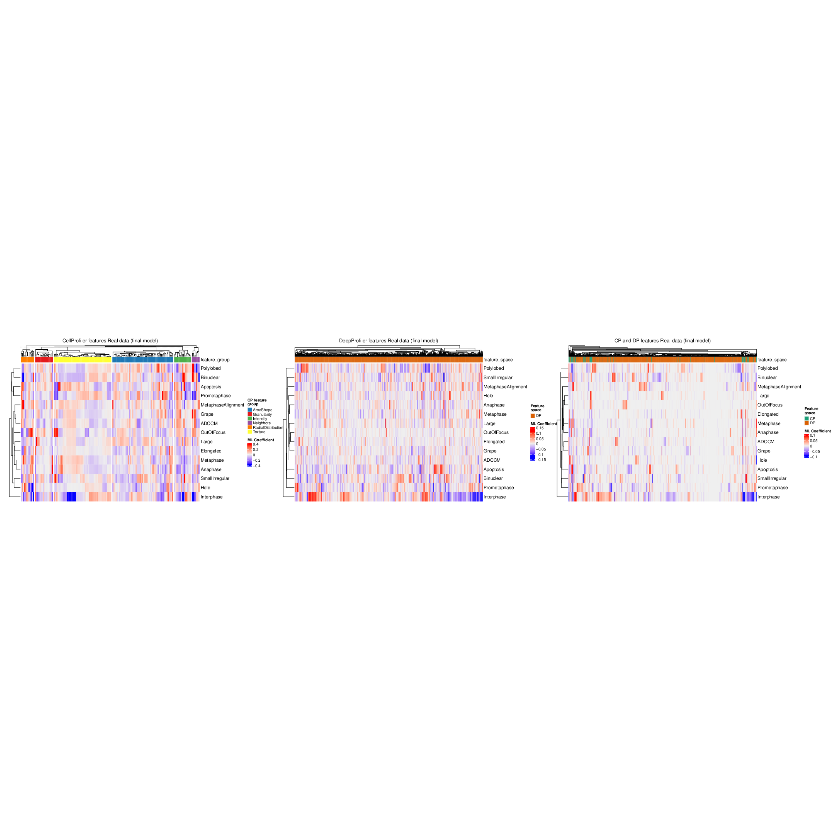

In [10]:
heatmap_top_gg